In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, mean_squared_error,r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import statsmodels.api as sm
import itertools
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from IPython.display import Image
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
weather_2011 = pd.read_csv('./cleaned datasets/weather data/clean_weather_2011.csv')
weather_2012 = pd.read_csv('./cleaned datasets/weather data/clean_weather_2012.csv')
weather_2013 = pd.read_csv('./cleaned datasets/weather data/clean_weather_2013.csv')
weather_2014 = pd.read_csv('./cleaned datasets/weather data/clean_weather_2014.csv')
weather_2015 = pd.read_csv('./cleaned datasets/weather data/clean_weather_2015.csv')
weather_2016 = pd.read_csv('./cleaned datasets/weather data/clean_weather_2016.csv')
weather_2017 = pd.read_csv('./cleaned datasets/weather data/clean_weather_2017.csv')
weather_2018 = pd.read_csv('./cleaned datasets/weather data/clean_weather_2018.csv')
weather_2019 = pd.read_csv('./cleaned datasets/weather data/clean_weather_2019.csv')

In [3]:
weather = pd.concat([weather_2011, weather_2012, weather_2013, weather_2014, weather_2015, weather_2016,
                     weather_2017, weather_2018, weather_2019])

In [4]:
weather.set_index('datetime', inplace = True)
weather.dropna(inplace = True)

weather.index = pd.DatetimeIndex(weather.index).to_period('D')
weather.index

PeriodIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
             '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
             '2011-01-09', '2011-01-10',
             ...
             '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
             '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
             '2019-12-30', '2019-12-31'],
            dtype='period[D]', name='datetime', length=3233, freq='D')

## looking at two year trends (2012 & 2013)

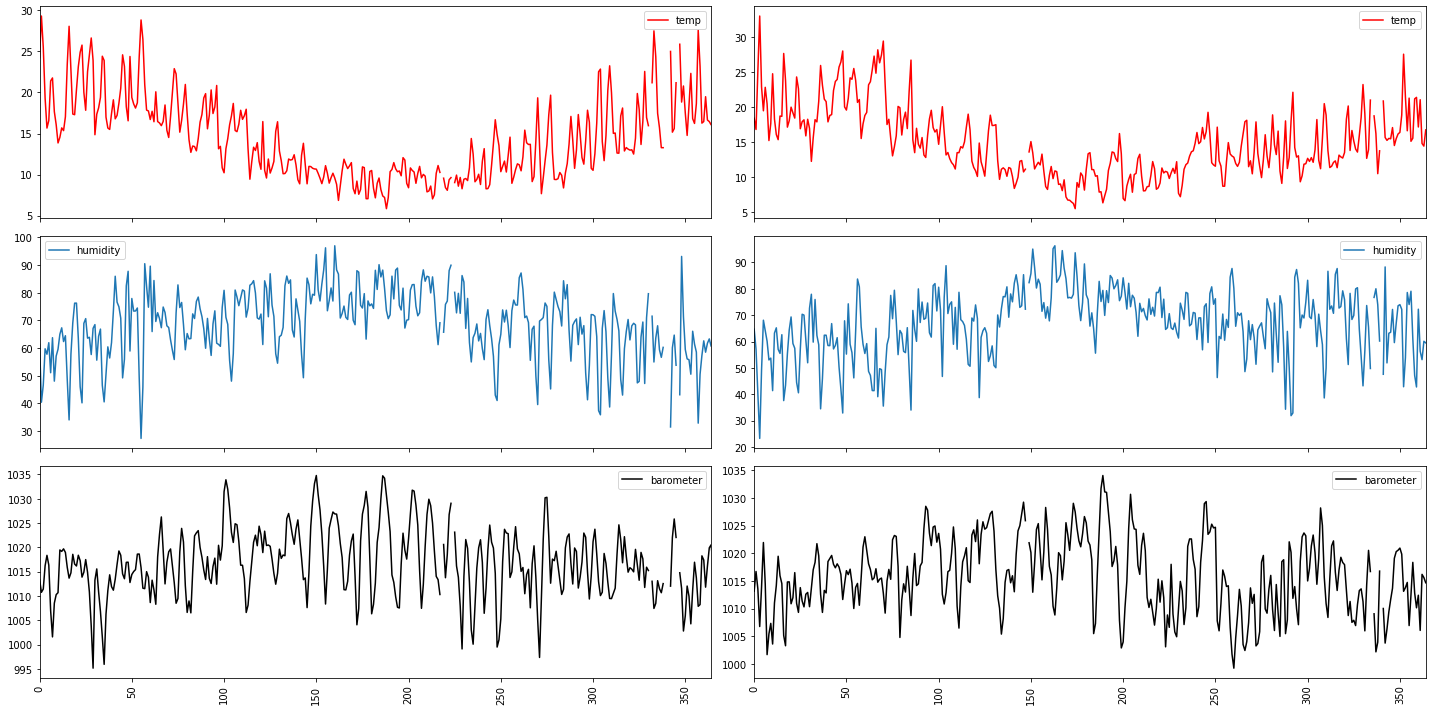

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (20,10), sharex = True)

weather_2012[['temp']].plot(rot = '90', ax = axes[0,0], c = 'r')
weather_2013[['temp']].plot(rot = '90', ax = axes[0,1], c = 'r')
weather_2012[['humidity']].plot(rot = '90', ax = axes[1,0])
weather_2013[['humidity']].plot(rot = '90', ax = axes[1,1])
weather_2012[['barometer']].plot(rot = '90', ax = axes[2,0], c = 'black')
weather_2013[['barometer']].plot(rot = '90', ax = axes[2,1], c = 'black')
plt.tight_layout();

## Import sensor data

In [7]:
sensors = pd.read_csv('./cleaned datasets/all_valid_sensors.csv')
sensors.head()

,year,month,day,weekday,hour,sensor_id,hourly_counts,datetime
0,2011,1,1,Saturday,0,2,985,2011-01-01 00:00:00
1,2011,1,1,Saturday,0,3,2547,2011-01-01 00:00:00
2,2011,1,1,Saturday,0,4,3514,2011-01-01 00:00:00
3,2011,1,1,Saturday,0,5,5021,2011-01-01 00:00:00
4,2011,1,1,Saturday,0,6,3514,2011-01-01 00:00:00


# Sensors 2, 6, 8, 9, 10, 11, 18 have valid records for all years, so start time series with these

## sensor 2 & 6 had slightly better scores without weather data, rest of sensors had slightly better scores with weather data

### Functions

#### returns data frame with average daily sensor counts for specified sensor

In [16]:
def daily_avg_ts(sensor_num):
    #get only time series data for sensor & make time series the index
    sensor = sensors[sensors.sensor_id ==sensor_num]
    sensor_time = sensor[['datetime', 'hourly_counts']]
    sensor_time.set_index('datetime', inplace = True)
    sensor_time.index = pd.DatetimeIndex(sensor_time.index).to_period('H')

    #resample to get daily average counts
    daily_sensor = sensor_time.resample('1D').mean()
    daily_sensor.dropna(inplace = True)
    daily_sensor.rename({'hourly_counts': 'daily_avg_counts'}, axis = 1, inplace = True)
    return daily_sensor

#### returns data frame with average daily sensor counts from specified sensor, joined with weather data from corresponding dates between 2011-2018



In [17]:
def join_sensor_weather(daily_avg_ts):
    
    #extract only data from 2011-2018
    sen_2011_2018 = daily_avg_ts.loc['2011-01-01': '2018-12-31']
    
    #join weather data on sensor2 data from 2011-2018, only on common indexes
    sensor_weather = pd.merge(weather, sen_2011_2018, left_index=True, right_index=True)

    return sensor_weather

#### find best parameters for time series, using only temp as an exog feature

In [18]:
def find_best_params(sensor_weather):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


    params = []
    param_seasonals = []
    all_results = []

    for param in pdq:
        for param_seasonal in seasonal_pdq:

            try:
                mod = sm.tsa.statespace.SARIMAX(sensor_weather.daily_avg_counts,
                                                exog=sensor_weather[['temp']],
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit(maxiter = 10000)
                params.append(param)
                param_seasonals.append(param_seasonal)
                all_results.append(results.aic)

               # print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue

    df = pd.DataFrame({'parameters': params, 'seasonal parameters': param_seasonals, 'AIC': all_results})
    
    return df.sort_values(by = 'AIC')

#### returns MSE and R2 scores and plot of predictions for time series. Put best order and seasonal found from above function

In [19]:
def get_result_features(sensor_weather, order1, order2, order3, seasonal1, seasonal2, seasonal3, sensor_num):


    model = sm.tsa.statespace.SARIMAX(sensor_weather.daily_avg_counts,
                                      exog=sensor_weather[['temp']],
                                      order=(order1, order2, order3),
                                      seasonal_order=(seasonal1, seasonal2, seasonal3, 12))
    results = model.fit(maxiter=1000)
    results.summary()


    print('MSE: ', mean_squared_error(sensor_weather.daily_avg_counts, results.predict())**0.5)
    print('R2 Score: ', r2_score(sensor_weather.daily_avg_counts, results.predict()))
    
    sensor_weather.index = sensor_weather.index.to_timestamp(freq = 'D')
    
    # setup index for out-of-sample forecasts
    forecast_end = 365
    forecasts_index = pd.bdate_range(start=sensor_weather.index[-1],
                                     periods=1+forecast_end,
                                     freq='D')


    # choose exogenous predictors for forecasting (just pick one predictor row and keep it)
    forecasts_exog = pd.DataFrame(data=np.repeat(sensor_weather.loc[sensor_weather.index.min()].temp, len(forecasts_index), axis=0),
                                  index=forecasts_index, columns = ['temp'])

    forecasts = results.predict(
        start=len(sensor_weather)-1, 
        end=len(sensor_weather)-1+forecast_end,
        dynamic=True,
        exog=forecasts_exog[1:])
    
    fig, ax = plt.subplots(figsize=(20, 16))
    sensor_weather.daily_avg_counts.plot(c='darksalmon', ax=ax)
    results.predict(dynamic=False).plot(c='peachpuff', label='non-dynamical foreacasting',ax=ax)
    forecasts.plot(c='firebrick', label='dynamical forecasting', ax=ax)
    plt.legend(prop={'size': 20})
    plt.savefig('sen{}_weather_ts.png'.format(sensor_num), bbox_inches='tight')
    plt.show()

## Sensor 2

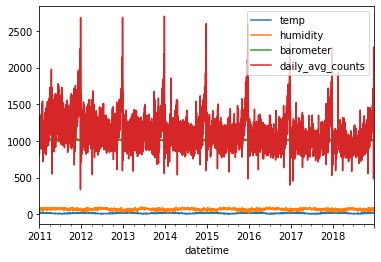

In [22]:
sensor_2_weather = join_sensor_weather(daily_avg_ts(2))
sensor_2_weather.plot();

In [21]:
find_best_params(sensor_2_weather)

,parameters,seasonal parameters,AIC
63,"(1, 1, 1)","(1, 1, 1, 12)",38307.162878
59,"(1, 1, 1)","(0, 1, 1, 12)",38323.482835
47,"(1, 0, 1)","(1, 1, 1, 12)",38370.852916
61,"(1, 1, 1)","(1, 0, 1, 12)",38376.157947
31,"(0, 1, 1)","(1, 1, 1, 12)",38382.674775
...,...,...,...
8,"(0, 0, 1)","(0, 0, 0, 12)",41343.781177
50,"(1, 1, 0)","(0, 1, 0, 12)",41457.738947
18,"(0, 1, 0)","(0, 1, 0, 12)",41716.855799
1,"(0, 0, 0)","(0, 0, 1, 12)",41983.686474


MSE:  203.21363988137335
R2 Score:  0.3057567402918294


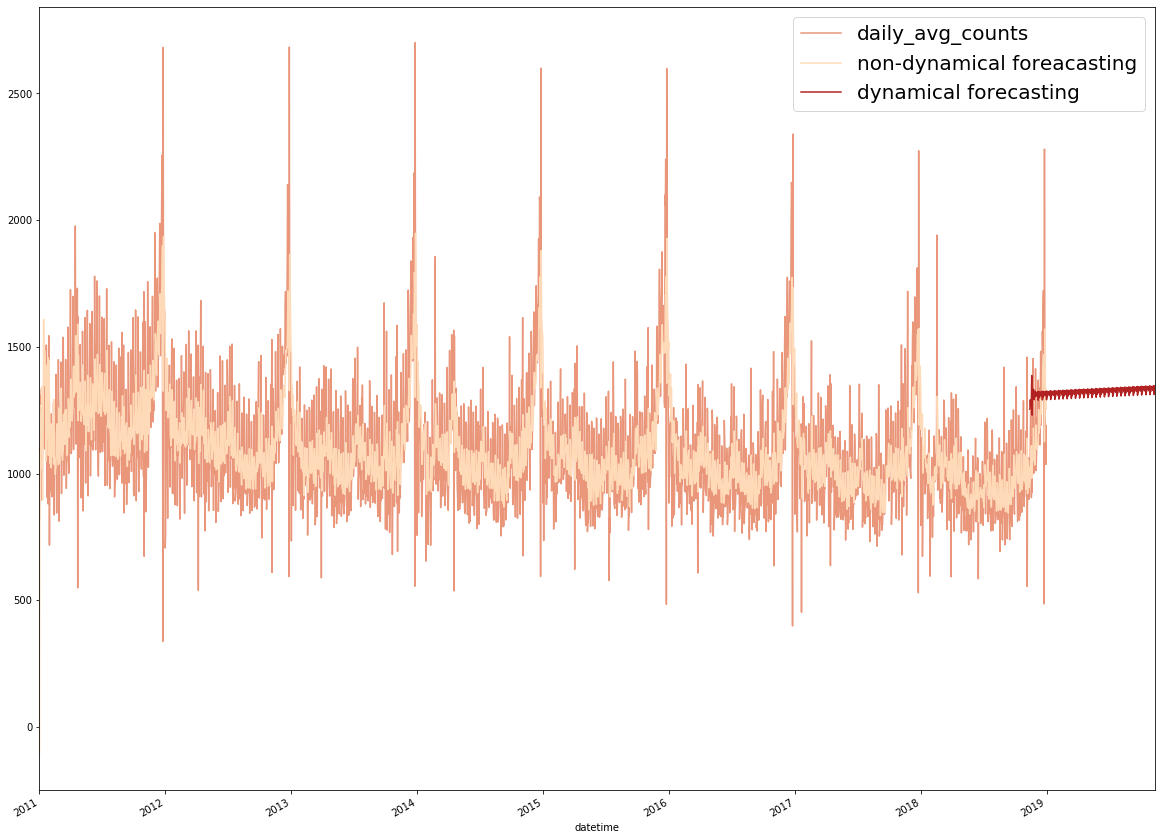

In [104]:
get_result_features(sensor_2_weather,1,1,1,1,1,1,2)

# without weather :
# Root MSE:  201.58448827952085
# R2 Score:  0.3170028733521483

## Sensor 6

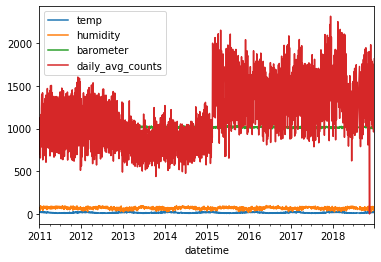

In [23]:
sensor_6_weather = join_sensor_weather(daily_avg_ts(6))
sensor_6_weather.plot();

In [24]:
find_best_params(sensor_6_weather)

,parameters,seasonal parameters,AIC
63,"(1, 1, 1)","(1, 1, 1, 12)",38715.871014
61,"(1, 1, 1)","(1, 0, 1, 12)",38760.224828
57,"(1, 1, 1)","(0, 0, 1, 12)",38771.250429
60,"(1, 1, 1)","(1, 0, 0, 12)",38835.083615
59,"(1, 1, 1)","(0, 1, 1, 12)",38856.199642
...,...,...,...
8,"(0, 0, 1)","(0, 0, 0, 12)",41846.337533
50,"(1, 1, 0)","(0, 1, 0, 12)",42680.551934
18,"(0, 1, 0)","(0, 1, 0, 12)",42728.558877
1,"(0, 0, 0)","(0, 0, 1, 12)",42831.831950


MSE:  249.56954041795476
R2 Score:  0.49280991151333553


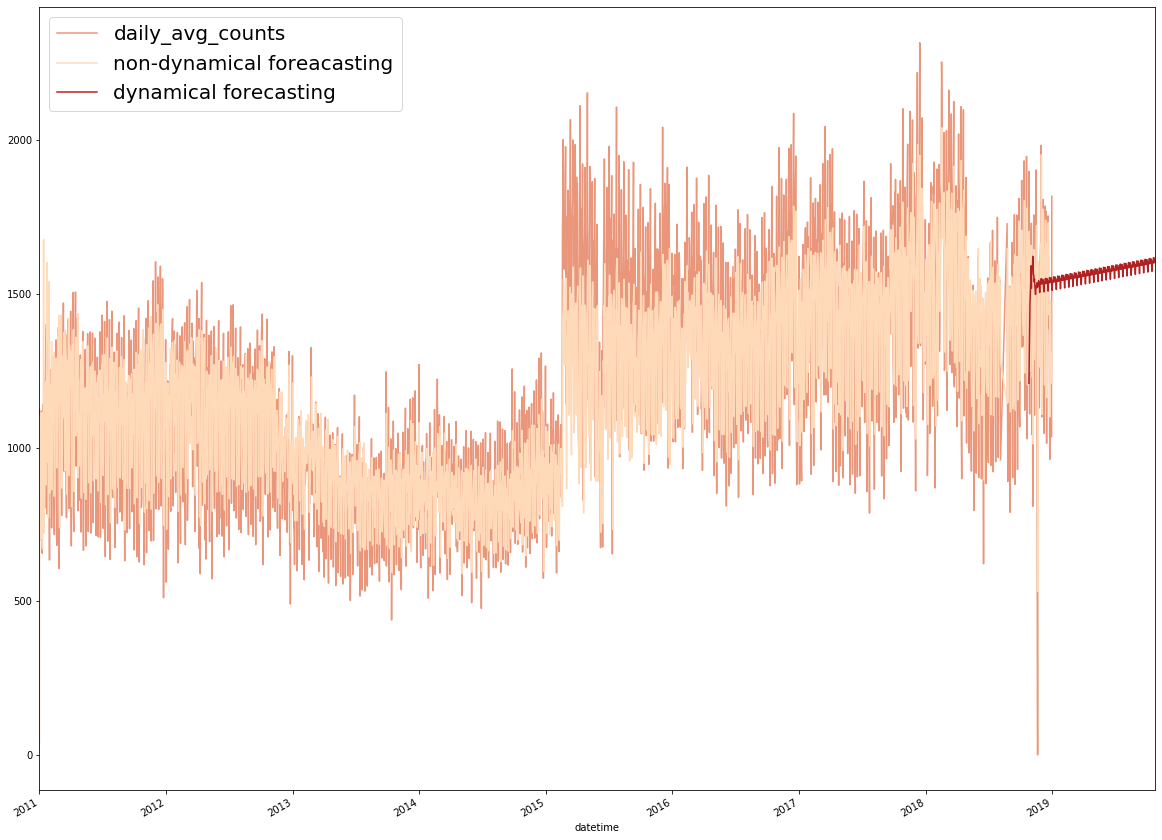

In [35]:
get_result_features(sensor_6_weather,1,1,1,1,1,1,2)

# without weather :
# Root MSE:  201.58448827952085
# R2 Score:  0.3170028733521483

## Sensor 8

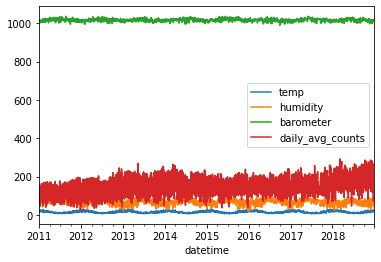

In [25]:
sensor_8_weather = join_sensor_weather(daily_avg_ts(8))
sensor_8_weather.plot();

In [26]:
find_best_params(sensor_8_weather)

,parameters,seasonal parameters,AIC
15,"(0, 0, 1)","(1, 1, 1, 12)",29173.386828
47,"(1, 0, 1)","(1, 1, 1, 12)",29173.648920
43,"(1, 0, 1)","(0, 1, 1, 12)",29219.807880
11,"(0, 0, 1)","(0, 1, 1, 12)",29226.541600
63,"(1, 1, 1)","(1, 1, 1, 12)",29227.484237
...,...,...,...
26,"(0, 1, 1)","(0, 1, 0, 12)",32036.321301
2,"(0, 0, 0)","(0, 1, 0, 12)",32048.035591
0,"(0, 0, 0)","(0, 0, 0, 12)",32104.834134
50,"(1, 1, 0)","(0, 1, 0, 12)",33089.610625


MSE:  42.84355141213224
R2 Score:  0.2401058474250264


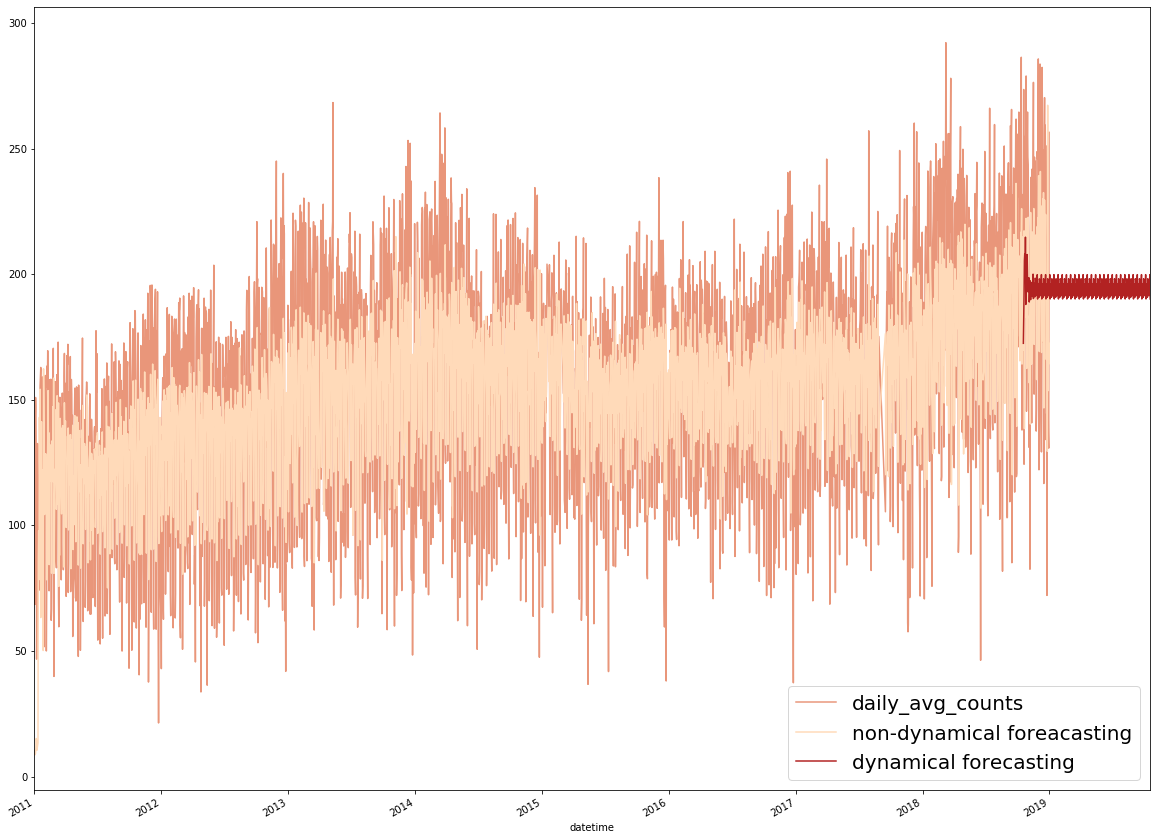

In [36]:
get_result_features(sensor_8_weather,0,0,1,1,1,1,2)

# without weather :
# Root MSE:  201.58448827952085
# R2 Score:  0.3170028733521483

## Sensor 9

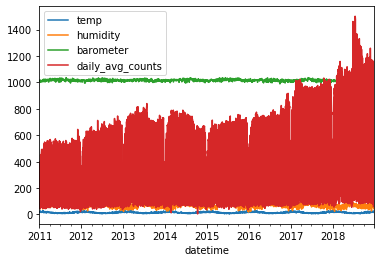

In [27]:
sensor_9_weather = join_sensor_weather(daily_avg_ts(9))
sensor_9_weather.plot();

In [28]:
find_best_params(sensor_9_weather)

,parameters,seasonal parameters,AIC
15,"(0, 0, 1)","(1, 1, 1, 12)",40129.196807
47,"(1, 0, 1)","(1, 1, 1, 12)",40131.136014
43,"(1, 0, 1)","(0, 1, 1, 12)",40205.371544
11,"(0, 0, 1)","(0, 1, 1, 12)",40206.622559
61,"(1, 1, 1)","(1, 0, 1, 12)",40378.186937
...,...,...,...
2,"(0, 0, 0)","(0, 1, 0, 12)",43645.229682
26,"(0, 1, 1)","(0, 1, 0, 12)",43769.449986
58,"(1, 1, 1)","(0, 1, 0, 12)",44124.380468
18,"(0, 1, 0)","(0, 1, 0, 12)",44588.938323


MSE:  284.1584665368667
R2 Score:  0.31960066938748455


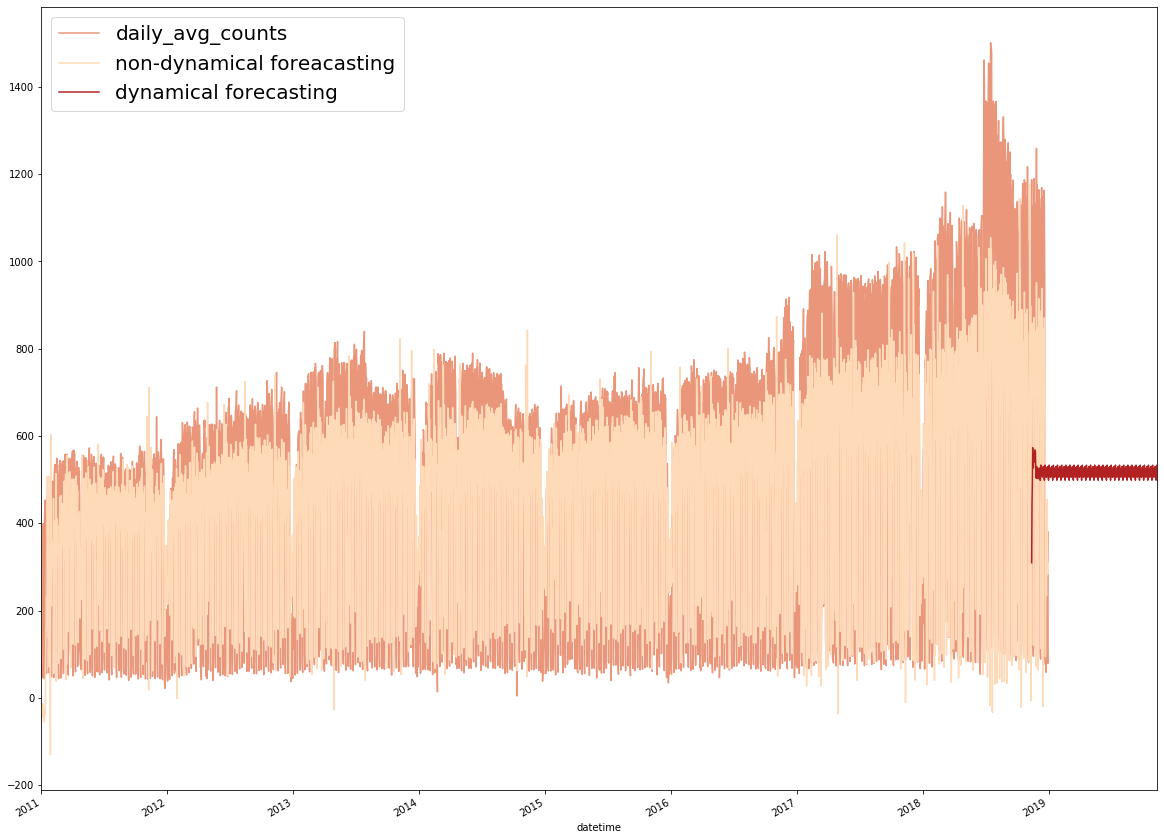

In [37]:
get_result_features(sensor_9_weather,0,0,1,1,1,1,2)

# without weather :
# Root MSE:  201.58448827952085
# R2 Score:  0.3170028733521483

## Sensor 10

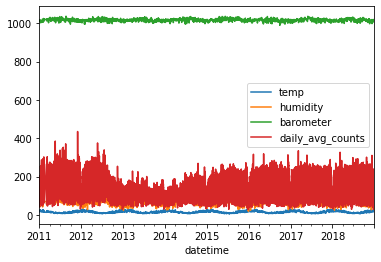

In [29]:
sensor_10_weather = join_sensor_weather(daily_avg_ts(10))
sensor_10_weather.plot();

In [30]:
find_best_params(sensor_10_weather)

,parameters,seasonal parameters,AIC
15,"(0, 0, 1)","(1, 1, 1, 12)",31775.983916
47,"(1, 0, 1)","(1, 1, 1, 12)",31777.819036
61,"(1, 1, 1)","(1, 0, 1, 12)",31828.405369
57,"(1, 1, 1)","(0, 0, 1, 12)",31839.970880
43,"(1, 0, 1)","(0, 1, 1, 12)",31857.591679
...,...,...,...
34,"(1, 0, 0)","(0, 1, 0, 12)",34808.035667
26,"(0, 1, 1)","(0, 1, 0, 12)",35021.922298
2,"(0, 0, 0)","(0, 1, 0, 12)",35036.098822
50,"(1, 1, 0)","(0, 1, 0, 12)",36058.065601


MSE:  69.31864879141621
R2 Score:  0.2462876204170844


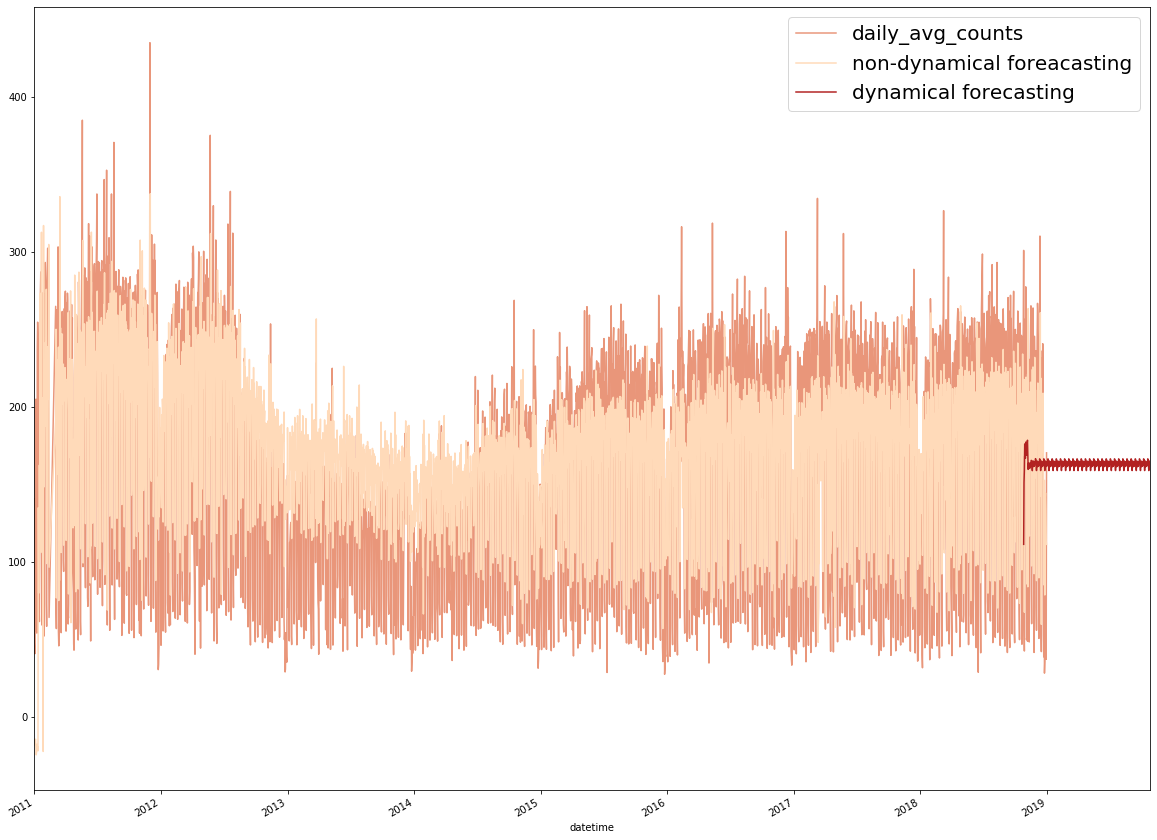

In [38]:
get_result_features(sensor_10_weather,0,0,1,1,1,1,2)

# without weather :
# Root MSE:  201.58448827952085
# R2 Score:  0.3170028733521483

## Sensor 11

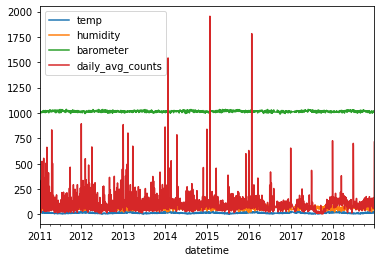

In [31]:
sensor_11_weather = join_sensor_weather(daily_avg_ts(11))
sensor_11_weather.plot();

In [32]:
find_best_params(sensor_11_weather)

,parameters,seasonal parameters,AIC
63,"(1, 1, 1)","(1, 1, 1, 12)",33429.748409
59,"(1, 1, 1)","(0, 1, 1, 12)",33434.550075
47,"(1, 0, 1)","(1, 1, 1, 12)",33442.343390
15,"(0, 0, 1)","(1, 1, 1, 12)",33443.002730
43,"(1, 0, 1)","(0, 1, 1, 12)",33444.745639
...,...,...,...
2,"(0, 0, 0)","(0, 1, 0, 12)",35670.751740
54,"(1, 1, 0)","(1, 1, 0, 12)",35728.825699
22,"(0, 1, 0)","(1, 1, 0, 12)",36082.850529
50,"(1, 1, 0)","(0, 1, 0, 12)",36623.273909


MSE:  95.97132619033837
R2 Score:  0.0375324716955987


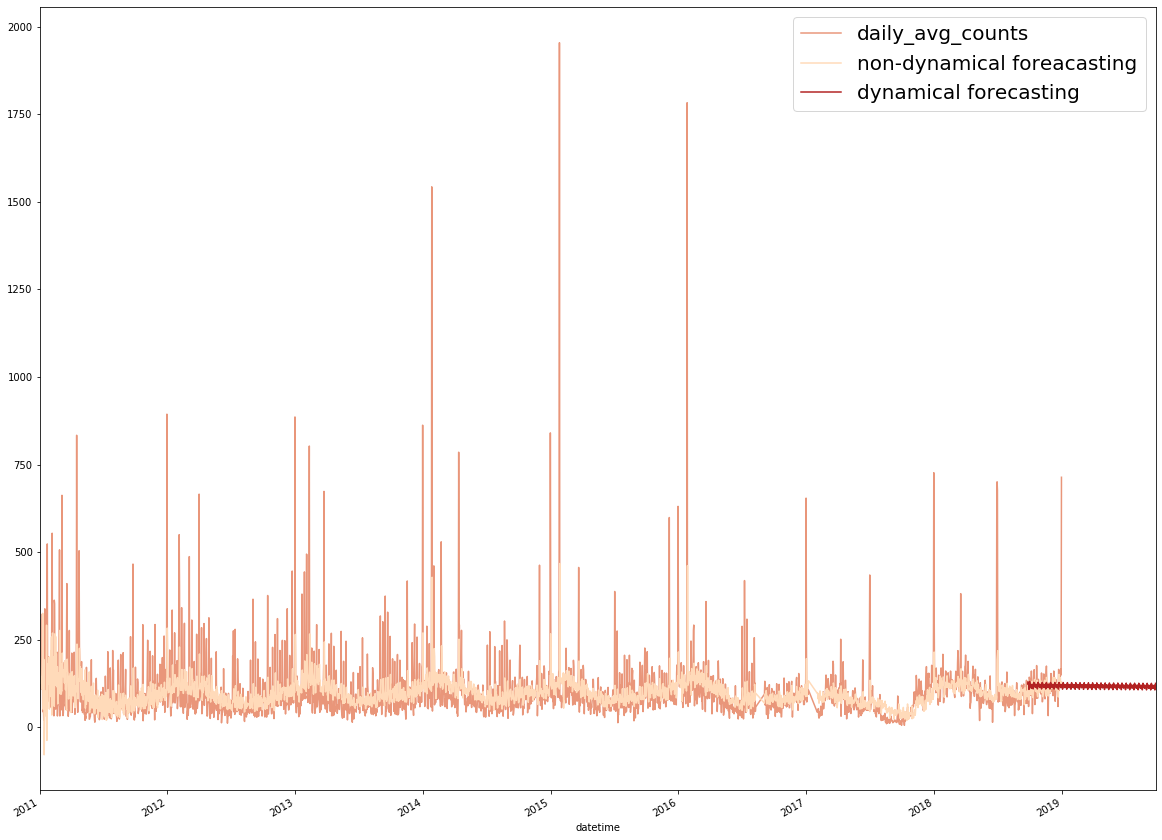

In [39]:
get_result_features(sensor_11_weather,1,1,1,1,1,1,2)

# without weather :
# Root MSE:  201.58448827952085
# R2 Score:  0.3170028733521483

## Sensor 18

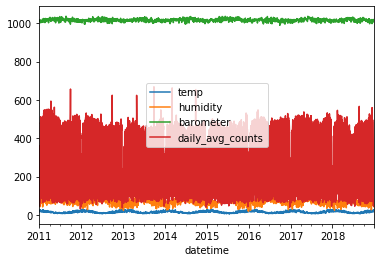

In [33]:
sensor_18_weather = join_sensor_weather(daily_avg_ts(18))
sensor_18_weather.plot();

In [34]:
find_best_params(sensor_18_weather)

,parameters,seasonal parameters,AIC
15,"(0, 0, 1)","(1, 1, 1, 12)",36554.426442
47,"(1, 0, 1)","(1, 1, 1, 12)",36556.384433
43,"(1, 0, 1)","(0, 1, 1, 12)",36656.261455
11,"(0, 0, 1)","(0, 1, 1, 12)",36659.937559
61,"(1, 1, 1)","(1, 0, 1, 12)",36839.827119
...,...,...,...
2,"(0, 0, 0)","(0, 1, 0, 12)",40220.797631
26,"(0, 1, 1)","(0, 1, 0, 12)",40339.586063
58,"(1, 1, 1)","(0, 1, 0, 12)",40721.406178
18,"(0, 1, 0)","(0, 1, 0, 12)",41131.770877


MSE:  150.08019925624356
R2 Score:  0.26820249869548207


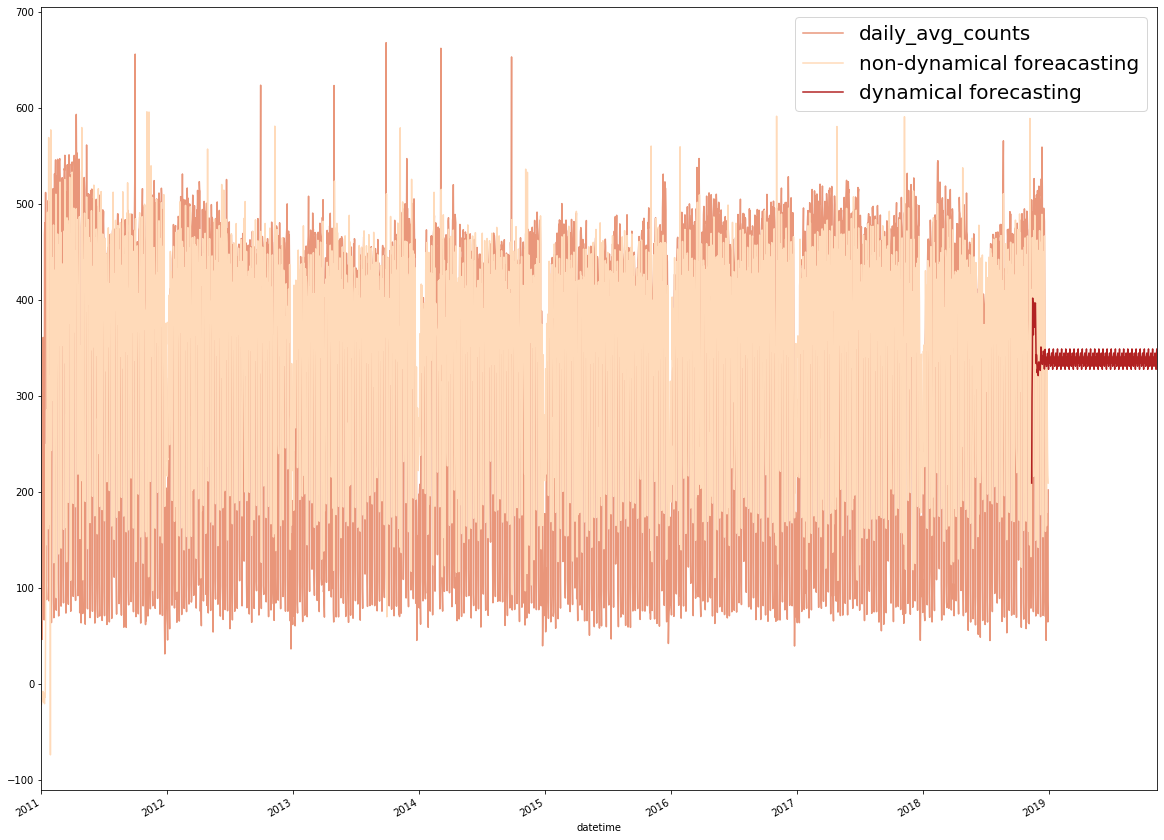

In [40]:
get_result_features(sensor_18_weather,0,0,1,1,1,1,2)

# without weather :
# Root MSE:  201.58448827952085
# R2 Score:  0.3170028733521483